Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [14]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import pandas as pd
%pylab inline
import seaborn as sns
from sklearn.externals import joblib
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'mean', 'zeros', 'text', 'random', 'cm', 'step', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
tf.__version__

'0.11.0rc0'

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()
    
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
        return 0
    
def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [6]:
batch_size=63
num_unrollings=10

class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()
    
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
    
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

# print(batches2string(train_batches.next()))
# print(batches2string(train_batches.next()))
# print(batches2string(valid_batches.next()))
# print(batches2string(valid_batches.next()))

In [7]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [8]:
num_nodes_start1 = 32
num_nodes_end1 = 32

num_nodes_start2 = 4
num_nodes_end2 = 32

In [16]:
num_nodes = num_nodes_start1
num_nodes2 = num_nodes_start2
vocabulary_size = 27 # !--- remove after testing     ---!

lstm_graph = tf.Graph()
with lstm_graph.as_default():
    
    mean = 0.
    stddev = 0.1
    # Parameters:
    init = tf.random_normal_initializer(mean=mean, stddev=stddev)
    zeros = tf.zeros_initializer
    # Input gate: input, previous output, and bias.
    ix = tf.get_variable('ix', [vocabulary_size, num_nodes], np.float32, init)
    im = tf.get_variable('im', [num_nodes, num_nodes], np.float32, init)
    ib = tf.get_variable('ib', [1, num_nodes], np.float32, init) #tf.zeros)
    # Forget gate: input, previous output, and bias.
    fx = tf.get_variable('fx', [vocabulary_size, num_nodes], np.float32, init)
    fm = tf.get_variable('fm', [num_nodes, num_nodes], np.float32, init)
    fb = tf.get_variable('fb', [1, num_nodes], np.float32, init)#tf.zeros)
    # Memory cell: input, state and bias.                                                         
    cx = tf.get_variable('cx', [vocabulary_size, num_nodes], np.float32, init)
    cm = tf.get_variable('cm', [num_nodes, num_nodes], np.float32, init)
    cb = tf.get_variable('cb', [1, num_nodes], np.float32, init)#tf.zeros)
    # Output gate: input, previous output, and bias.
    ox = tf.get_variable('ox', [vocabulary_size, num_nodes], np.float32, init)
    om = tf.get_variable('om', [num_nodes, num_nodes], np.float32, init)
    ob = tf.get_variable('ob', [1, num_nodes], np.float32, init)#tf.zeros)

    # Variables saving state across unrollings.
    saved_output = tf.get_variable('saved_output', [batch_size, num_nodes], np.float32, zeros, trainable=False)
    saved_state = tf.get_variable('saved_state', [batch_size, num_nodes], np.float32, zeros, trainable=False)

    saved_sample_output = tf.get_variable('saved_sample_output', [1, num_nodes], np.float32, zeros, )
    saved_sample_state = tf.get_variable('saved_sample_state', [1, num_nodes], np.float32, zeros, )
    
    # Input gate: input, previous output, and bias.
    ix2 = tf.get_variable('ix2', [vocabulary_size + num_nodes, num_nodes2], np.float32, init)
    im2 = tf.get_variable('im2', [num_nodes2, num_nodes2], np.float32, init)
    ib2 = tf.get_variable('ib2', [1, num_nodes2], np.float32, init) #tf.zeros)
    # Forget gate: input, previous output, and bias.
    fx2 = tf.get_variable('fx2', [vocabulary_size + num_nodes, num_nodes2], np.float32, init)
    fm2 = tf.get_variable('fm2', [num_nodes2, num_nodes2], np.float32, init)
    fb2 = tf.get_variable('fb2', [1, num_nodes2], np.float32, init)#tf.zeros)
    # Memory cell: input, state and bias.                                                         
    cx2 = tf.get_variable('cx2', [vocabulary_size + num_nodes, num_nodes2], np.float32, init)
    cm2 = tf.get_variable('cm2', [num_nodes2, num_nodes2], np.float32, init)
    cb2 = tf.get_variable('cb2', [1, num_nodes2], np.float32, init)#tf.zeros)
    # Output gate: input, previous output, and bias.
    ox2 = tf.get_variable('ox2', [vocabulary_size + num_nodes, num_nodes2], np.float32, init)
    om2 = tf.get_variable('om2', [num_nodes2, num_nodes2], np.float32, init)
    ob2 = tf.get_variable('ob2', [1, num_nodes2], np.float32, init)#tf.zeros)
    
    # Variables saving state across unrollings.
    saved_output2 = tf.get_variable('saved_output2', [batch_size, num_nodes2], np.float32, zeros, trainable=False)
    saved_state2 = tf.get_variable('saved_state2', [batch_size, num_nodes2], np.float32, zeros, trainable=False)

    saved_sample_output2 = tf.get_variable('saved_sample_output2', [1, num_nodes2], np.float32, zeros, )
    saved_sample_state2 = tf.get_variable('saved_sample_state2', [1, num_nodes2], np.float32, zeros, )
    
    # Classifier weights and biases.
    w = tf.get_variable('w', [num_nodes + num_nodes2, vocabulary_size], np.float32, init)
#     w2 = tf.get_variable('w2', [num_nodes2, vocabulary_size], np.float32, init)
    b = tf.get_variable('b', [vocabulary_size], np.float32, zeros)
    
    # Definition of topological operations
    x_gates = [ix, fx, cx, ox]
    m_gates = [im, fm, cm, om]
    b_gates = [ib, fb, cb, ob]

    x2_gates = [ix2, fx2, cx2, ox2]
    m2_gates = [im2, fm2, cm2, om2]
    b2_gates = [ib2, fb2, cb2, ob2]

    def duplicate_to_second_level(cell_indx, session,):

        # copy part
        for x, m, x2 in zip(x_gates, m_gates, x2_gates):
            concat = np.vstack([session.run(x)[:,[cell_indx]], session.run(m)[:,[cell_indx]]])
            j = np.hstack([session.run(x2), concat])
            session.run(tf.assign(x2, j, validate_shape=False))
            
        j = session.run(w)
        j[[cell_indx], :] *= 0.5
        slc = j[[cell_indx], :]
        # slc += stddev_ * np.random.randn(*slc.shape) + mean
        j = np.vstack([j, slc])

        session.run(tf.assign(w, j, validate_shape=False))

        # random part
        stddev_ = 0.1
        k = 0.
        
        cell_indx = 0    
        
        for i in m2_gates:
            
            j = session.run(i)
            slc = j[:, [cell_indx]] * k
            slc += stddev_ * np.random.randn(*slc.shape) + mean
            j = np.hstack([j, slc])

            slc = j[[cell_indx], :] * k
            slc += stddev_ * np.random.randn(*slc.shape) + mean
            j = np.vstack([j, slc])
            
            session.run(tf.assign(i, j, validate_shape=False))

        for i in b2_gates:
            j = session.run(i)
            slc = j[:, [cell_indx]] * k
            slc += stddev_ * np.random.randn(*slc.shape) + mean
            j = np.hstack([j, slc])

            session.run(tf.assign(i, j, validate_shape=False))
        
        reset_state(session)
        
    def reset_state(sess):
        
        # layer 1
        nn_size1 = sess.run(ix).shape[1]
        
        for i in saved_output, saved_state:
            j = np.zeros([batch_size, nn_size1])
            sess.run(tf.assign(i, j, validate_shape=False))

        for i in saved_sample_output, saved_sample_state:
            j = np.zeros([1, nn_size1])
            sess.run(tf.assign(i, j, validate_shape=False))
        
        # layer 2
        nn_size2 = sess.run(ix2).shape[1]
        
        for i in saved_output2, saved_state2:
            j = np.zeros([batch_size, nn_size2])
            sess.run(tf.assign(i, j, validate_shape=False))

        for i in saved_sample_output2, saved_sample_state2:
            j = np.zeros([1, nn_size2])
            sess.run(tf.assign(i, j, validate_shape=False))
        
    def merge_cells(cell_1, cell_2):
        return

    # Definition of the cell computation.
    def lstm_cell(i, o, state, x_gates, m_gates, b_gates):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        
        ix, fx, cx, ox = x_gates
        im, fm, cm, om = m_gates
        ib, fb, cb, ob = b_gates
        
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]    # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    print(output.get_shape())
    print(state.get_shape())

    outputs2 = list()
    output2 = saved_output2
    state2 = saved_state2
    
    for i in train_inputs:
        output, state = lstm_cell(i, output, state, x_gates, m_gates, b_gates)
        outputs.append(output)

        input2 = tf.concat(1, [i, output])
        output2, state2 = lstm_cell(input2, output2, state2, x2_gates, m2_gates, b2_gates)
        outputs2.append(output2)
    #print(tf.concat(0, outputs).get_shape())

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output), # ?
                                  saved_state.assign(state), # ?
                                  saved_output2.assign(output2),
                                  saved_state2.assign(state2)]):
        # Classifier.
        print(tf.concat(1, [tf.concat(0, outputs), tf.concat(0, outputs2)]).get_shape())
#         print(tf.concat(0, [w, w2]).get_shape())
        logits = tf.nn.xw_plus_b(tf.concat(1, [tf.concat(0, outputs), tf.concat(0, outputs2)]), 
                                 w, b)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, train_labels)))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    gradients, v = zip(*optimizer.compute_gradients(loss, [im2]))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)
    
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    # reset_state()
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state, x_gates, m_gates, b_gates)
    sample_input2 = tf.concat(1, [sample_input, sample_output])
    sample_output2, sample_state2 = lstm_cell(
        sample_input2, saved_sample_output2, saved_sample_state2, x2_gates, m2_gates, b2_gates)
    
#     print(saved_output.get_shape())
#     print(saved_sample_state.get_shape(), sample_state.get_shape())
#     print(saved_sample_state2.get_shape(), sample_state2.get_shape())
    print(sample_output2.get_shape(), w.get_shape())
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state),
                                  saved_sample_output2.assign(sample_output2),
                                  saved_sample_state2.assign(sample_state2)
                                 ]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat(1, [sample_output, sample_output2]), 
                                                          w, b))
        print(tf.concat(1, [sample_output, sample_output2]).get_shape())

(63, 32)
(63, 32)
(630, 36)
(1, 4) (36, 27)
(1, 36)


Main loop
---------

In [19]:
# %%time

# if num_nodes_start == num_nodes_end: modes = [None]
# else: modes = ['mask_half', 'default', 'random']
    
modes = ['random']
# modes = ['default']

for duplication_mode in modes:
    start_iter = 1
    
    summary_frequency = 100
    num_steps = np.max([7001, 
                        (start_iter + num_nodes_end1 - num_nodes_start1) * summary_frequency + 1001,
                        (start_iter + num_nodes_end2 - num_nodes_start2) * summary_frequency + 1001,
                       ])
    num_steps = 10001
    
    mean_loss = [0]
    mean_valid_pplxt = []
    mean_train_pplxt = []
#     num_cells = [num_nodes_start]
    v_list = []

    with tf.Session(graph=lstm_graph) as session:
        
        e = 0
        tf.initialize_all_variables().run()
        nn_size1 = session.run(im).shape[0]
        nn_size2 = session.run(im2).shape[0]
        print('LSTM size', nn_size1, nn_size2)
        print('Initialized')

        if 0:
            
            for i in tqdm(range(num_nodes_end2 - nn_size2)):
                dup_cell = np.random.randint(0, high = nn_size1)
                duplicate_to_second_level(dup_cell, session)

#                 dup_cell = np.random.randint(0, high = nn_size)
#                 duplicate_cell(dup_cell, session)

        nn_size1 = session.run(im).shape[0]
        nn_size2 = session.run(im2).shape[0]
        print('LSTM size', nn_size1, nn_size2)

        for step in range(num_steps):
#             print(session.run(ix2)[:,0])
            
            batches = train_batches.next()
            feed_dict = dict()
            for i in range(num_unrollings + 1):
    #             print(batches[i].shape)
                feed_dict[train_data[i]] = batches[i]

            _, l, predictions, lr, v_ = session.run(
                [optimizer, loss, train_prediction, learning_rate, v], feed_dict=feed_dict)
            mean_loss[-1] += l
            print(v_.shape)
#             v_list += [v_.copy()]
#             print(gr.shape, v_.shape)
#             break
            if step % summary_frequency == 0:
        
#                 if step % (summary_frequency * 10) == 0:
#                     pd.DataFrame(v_list[-1]).loc[:,:7].hist(figsize=(16,6), bins=32, )

                mean_loss[-1] /= summary_frequency

                sim_log = (step, mean_loss[-1], lr)
                mean_loss += [0]
                labels = np.concatenate(list(batches)[1:])
                min_b_pplxt = float(np.exp(logprob(predictions, labels)))
                #print('Minibatch perplexity: %.2f' % float(

                if step % (summary_frequency * int(num_steps / summary_frequency)) == 0:
                    # Generate some samples.
                    print('=' * 80)
                    for _ in range(0):
                        feed = sample(random_distribution())
                        sentence = characters(feed)[0]
                        reset_state(session)
                        for _ in range(79):
                            prediction = sample_prediction.eval({sample_input: feed})
                            feed = sample(prediction)
                            sentence += characters(feed)[0]
                        print(sentence)
                    print('=' * 80)            
                    print('step | avrg loss | learn rate | batch pplxt | valid pplxt')
                # Measure validation set perplexity.
                reset_state(session)
                valid_logprob = 0
                for _ in range(0):
                    vb = valid_batches.next()
                    predictions = sample_prediction.eval({sample_input: vb[0]})
                    valid_logprob = valid_logprob + logprob(predictions, vb[1])
                valid_pplxt = float(np.exp(valid_logprob / valid_size))
                print ('%d             %.2f             %.2f                ' % sim_log, 
                             '%.2f                %.2f' % (min_b_pplxt, valid_pplxt))
                mean_valid_pplxt += [valid_pplxt]
                mean_train_pplxt += [min_b_pplxt]
                
                # edit network
                if step > 0 and step % 100 == 0:
    #                 pass
                    nn_size1 = session.run(im).shape[0]
                    nn_size2 = session.run(im2).shape[0]
                    if nn_size2 < num_nodes_end2 and step / summary_frequency >= start_iter: \
#                         and (-np.diff(pd.Series(mean_loss[1:-1]).rolling(4).mean()))[-1] < 0.01 \
#                         and step - e > 500:
                        
                        print('LSTM size', nn_size1, nn_size2)
                    
#                         t = np.vstack(v_list[-10:])
#                         t = np.std(t, axis=0)
#                         if np.min(t) < 0.20:
#                             rem_cell = np.argmax(t)
#                             remove_cell(rem_cell, session)
#                             print('neuron {} removed'.format(rem_cell))
                        
#                         dup_cell = np.argmin(np.abs(v_).sum(0))
                        e = step
                        for iw in range(1):
                            dup_cell = np.random.randint(0, high = nn_size1)
                            #duplicate_cell(dup_cell, session, mode=duplication_mode)
                            duplicate_to_second_level(dup_cell, session)
                            print('neuron',dup_cell,'duplicated.')
                        #print(session.run(ix2).shape[1])
#                         num_cells += [nn_size + 1]
                    else:
                        pass
#                         num_cells += [nn_size]
        # plot
        # pl()
        
        d = {}
        d.update(
#                  num_nodes_start = num_nodes_start,
#                  num_nodes_end = num_nodes_end,
#                  duplication_mode = (duplication_mode if num_nodes_start < num_nodes_end else None),
                 mean_loss = mean_loss,
#                  num_cells = num_cells,
                 mean_valid_pplxt = mean_valid_pplxt,
                 mean_train_pplxt = mean_train_pplxt,
                 num_steps = num_steps,
                 summary_frequency = summary_frequency,
                 start_iter = start_iter,
#                  v_list = v_list,
                 )
        results += [d.copy()]

LSTM size 32 4
Initialized
LSTM size 32 4


TypeError: Fetch argument array([[-0.10176904, -0.20444179, -0.08162673, -0.06284951],
       [-0.00545809, -0.1058931 ,  0.06071493, -0.08706645],
       [-0.06364456, -0.15612511,  0.11557885, -0.073906  ],
       [ 0.07200089, -0.08163841,  0.09938275,  0.03927141]], dtype=float32) has invalid type <type 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [ ]:
gradients, v = zip(*optimizer.compute_gradients(loss))

In [79]:
len(results)

6

In [82]:
results[0]['desc'] = '32, 4->32, each 100, num_unrollings==30'
results[1]['desc'] = '32, 4->32, each 100, num_unrollings==20'
results[2]['desc'] = '32, 4->32, each 100, num_unrollings==10'
results[3]['desc'] = '32, 4->32, x4 each 400, num_unrollings==10'
results[4]['desc'] = '32, 4->32, x4 when loss doesnt drop 4 steps (end 6k), num_unrollings==10'
results[5]['desc'] = '32, 4->32, x2 when loss doesnt drop 5 steps (end 10k), num_unrollings==10'

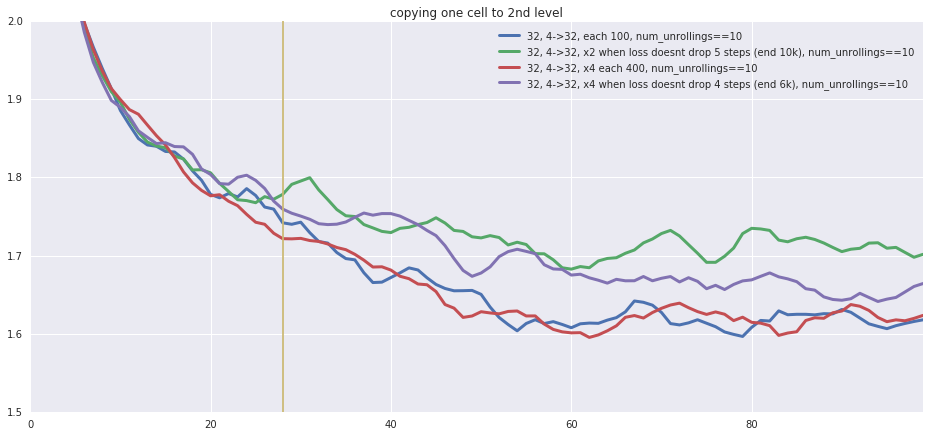

In [86]:
pd.DataFrame({'{}'.format(results[2]['desc']): results[2]['mean_loss'][1:-1],
              '{}'.format(results[3]['desc']): results[3]['mean_loss'][1:-1],
              '{}'.format(results[4]['desc']): results[4]['mean_loss'][1:-1],
              '{}'.format(results[5]['desc']): results[5]['mean_loss'][1:-1],
             }
            ).rolling(4).mean(
            #).ewm(alpha=0.3).mean(
                ).plot(figsize=(16,7), title='copying one cell to 2nd level', lw=3)
plt.ylim(1.5, 2.)
plt.plot([28,28], [1,2])

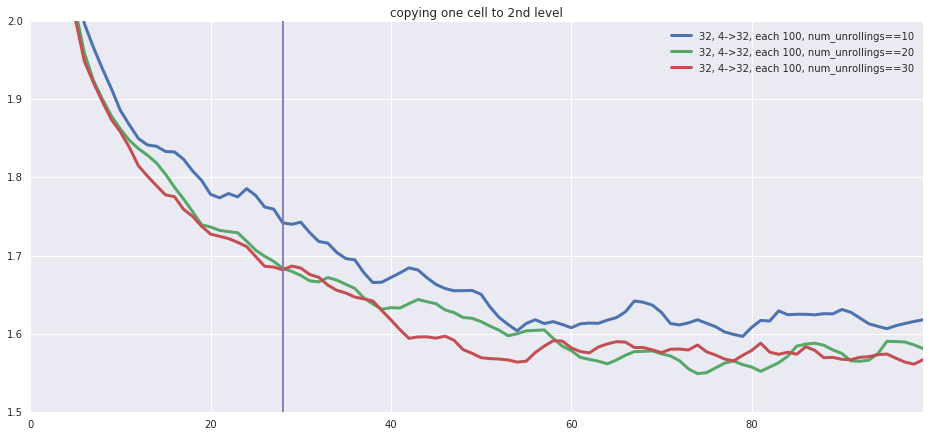

In [85]:
pd.DataFrame({'{}'.format(results[0]['desc']): results[0]['mean_loss'][1:-1],
              '{}'.format(results[1]['desc']): results[1]['mean_loss'][1:-1],
              '{}'.format(results[2]['desc']): results[2]['mean_loss'][1:-1],
             }
            ).rolling(4).mean(
            #).ewm(alpha=0.3).mean(
                ).plot(figsize=(16,7), title='copying one cell to 2nd level', lw=3)
plt.ylim(1.5, 2.)
plt.plot([28,28], [1,2])

(1.5, 2.0)

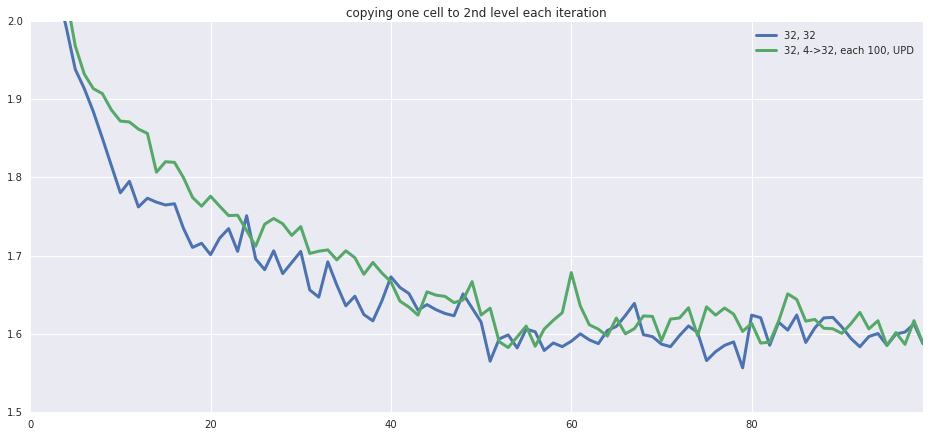

In [80]:
pd.DataFrame({'32, 32': results[0]['mean_loss'][1:-1],
#               '32, 4->32, each 300': results[1]['mean_loss'][1:-1],
#               '32, 4->32, each 100': results[2]['mean_loss'][1:-1] + [2.] * (len(results[0]['mean_loss'])
#                                                                                  - len(results[2]['mean_loss'])),
              '32, 4->32, each 100, UPD': results[3]['mean_loss'][1:-1],
             }#).ewm(alpha=0.3).mean(
                ).plot(figsize=(16,7), title='copying one cell to 2nd level each iteration', lw=3)
plt.ylim(1.5, 2.)

In [110]:
results[0]['mean_loss'][-10:]

[1.7838335835933685,
 1.8022380089759826,
 1.8140237092971803,
 1.8078404200077056,
 1.793756492137909,
 1.8016515684127807,
 1.8086296510696411,
 1.8022693765163422,
 1.8230134570598602,
 0]

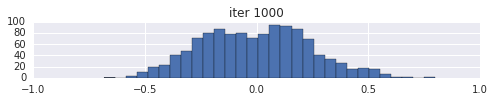

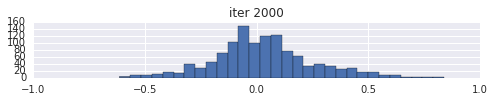

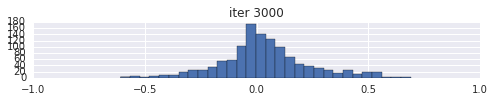

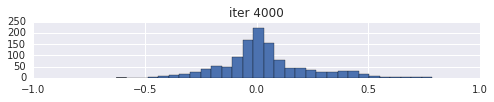

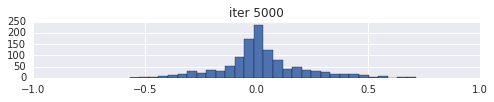

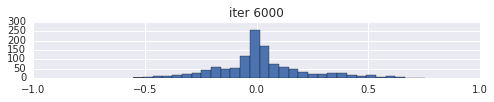

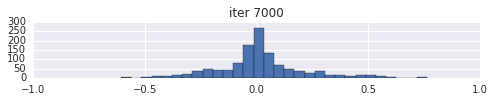

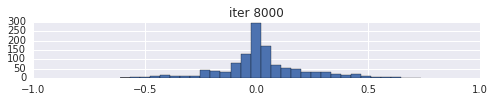

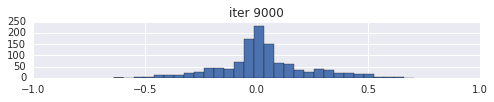

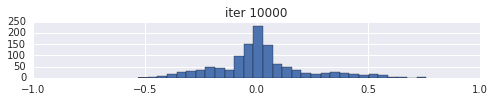

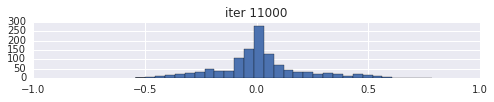

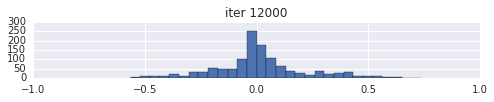

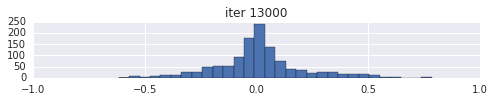

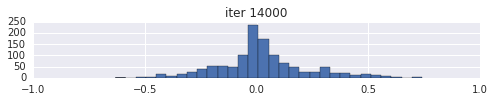

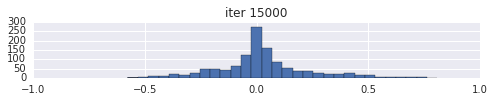

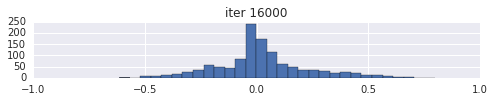

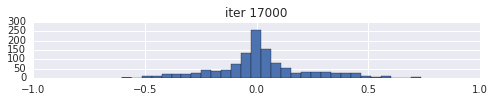

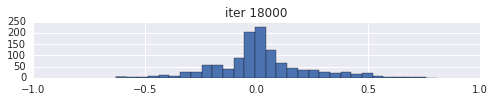

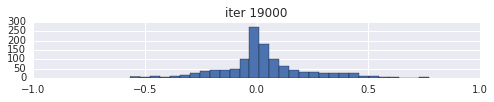

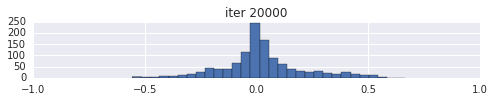

In [101]:
xl = []

for i in range(len(v_list)):
    if i % 1000 > 980:
        xl += [v_list[i]]
    if i % 1000 == 0 and len(xl) > 0:
        f, ax = subplots(1, 1)
        pd.DataFrame(np.vstack(xl)).loc[:,32].hist(figsize=(8,1), bins=30, ax=ax)
        ax.set_title('iter {}'.format(i))
        ax.set_xlim(-1,1)
        xl = []

In [29]:
for i in range(64):
    t = np.vstack(v_list[-10:])[:,i]
    hist = np.histogram(t, range=(-1,1), bins=20, normed=True)
    print(i)
    print('middle {:.1f}'.format(hist[0][10] + hist[0][11]))
    print('std {:.2f}, mean {:.2f}'.format(np.std(t), np.mean(t)))

0
middle 1.0
std 0.43, mean 0.02
1
middle 2.7
std 0.25, mean 0.01
2
middle 2.8
std 0.24, mean 0.02
3
middle 2.5
std 0.25, mean 0.03
4
middle 3.6
std 0.24, mean 0.05
5
middle 4.7
std 0.22, mean 0.00
6
middle 2.2
std 0.28, mean -0.01
7
middle 3.0
std 0.23, mean 0.04
8
middle 2.8
std 0.27, mean -0.01
9
middle 1.9
std 0.29, mean 0.05
10
middle 2.3
std 0.23, mean 0.03
11
middle 3.7
std 0.18, mean -0.02
12
middle 3.4
std 0.35, mean -0.06
13
middle 4.5
std 0.22, mean -0.02
14
middle 3.1
std 0.22, mean 0.05
15
middle 3.0
std 0.31, mean -0.04
16
middle 3.7
std 0.25, mean -0.03
17
middle 2.6
std 0.39, mean -0.07
18
middle 3.4
std 0.22, mean -0.02
19
middle 3.0
std 0.36, mean 0.09
20
middle 3.0
std 0.30, mean -0.09
21
middle 3.2
std 0.33, mean -0.04
22
middle 2.1
std 0.30, mean -0.04
23
middle 3.5
std 0.26, mean -0.00
24
middle 2.5
std 0.30, mean 0.01
25
middle 2.3
std 0.23, mean -0.08
26
middle 3.1
std 0.32, mean 0.04
27
middle 1.5
std 0.21, mean -0.06
28
middle 2.5
std 0.27, mean -0.04
29
middl

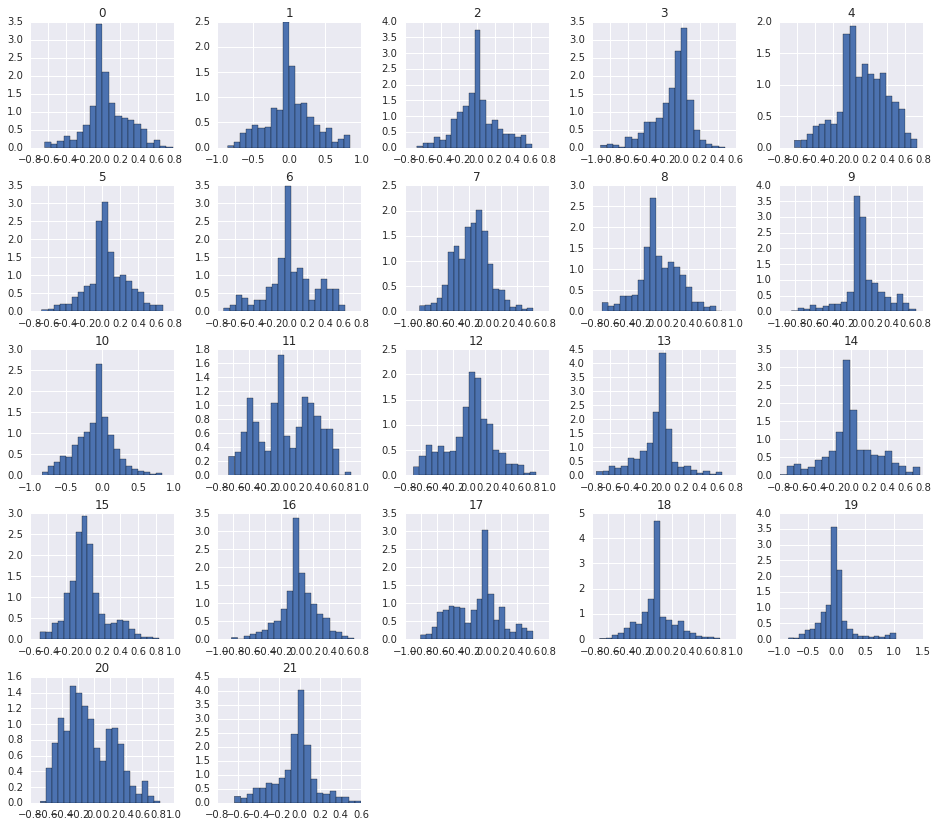

In [81]:
# fig, ax = plt.subplots(1, 1,)
ax = pd.DataFrame(np.vstack(v_list[-10:])).loc[:,:].hist(figsize=(16,14), bins=20, normed=True) ;

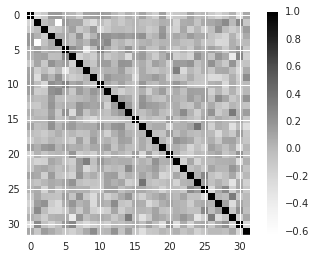

In [121]:
t = pd.DataFrame(np.vstack(results[2]['v_list'][-10:]))
plt.imshow(t.corr('pearson'), interpolation='none')
plt.colorbar()

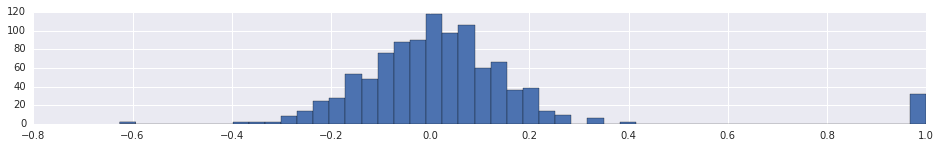

In [122]:
pd.Series(np.array(t.corr('pearson')).ravel()).hist(bins=50, figsize=(16,2))

In [87]:
# !mkdir ag_results
joblib.dump(results, 'ag_results/results ' + str(pd.Timestamp.now())[:-7])

['ag_results/results 2016-10-11 15:27:08']

In [14]:
with tf.Session(graph=lstm_graph) as session:
    tf.initialize_all_variables().run()
    nn_size = session.run(w).shape[0]
    print('LSTM size', nn_size)
    print('Initialized')

    nn_size = session.run(w).shape[0]
    print('LSTM size', nn_size)

    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
    #             print(batches[i].shape)
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr, gr, v_ = session.run(
            [optimizer, loss, train_prediction, learning_rate, gradients[10], v[10]], feed_dict=feed_dict)
        break
        mean_loss[-1] += l

        if step % summary_frequency == 0:

            mean_loss[-1] /= summary_frequency
            if step > 0:
    #                 pass
                nn_size = session.run(w).shape[0]
                if nn_size < num_nodes_end and step / summary_frequency >= start_iter:
                    print('LSTM size', nn_size, )
                    dup_cell = np.random.randint(0, high = nn_size)
                    duplicate_cell(dup_cell, session, mode=duplication_mode)
                    print('neuron',dup_cell,'duplicated.')
                    num_cells += [nn_size + 1]
                else:
                    num_cells += [nn_size]

            sim_log = (step, mean_loss[-1], lr)
            mean_loss += [0]
            labels = np.concatenate(list(batches)[1:])
            min_b_pplxt = float(np.exp(logprob(predictions, labels)))
            #print('Minibatch perplexity: %.2f' % float(

            if step % (summary_frequency * int(num_steps / summary_frequency)) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_state(session)
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)            
                print('step | avrg loss | learn rate | batch pplxt | valid pplxt')
            # Measure validation set perplexity.
            reset_state(session)
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            valid_pplxt = float(np.exp(valid_logprob / valid_size))
            print ('%d             %.2f             %.2f                ' % sim_log, 
                         '%.2f                %.2f' % (min_b_pplxt, valid_pplxt))
            mean_valid_pplxt += [valid_pplxt]
            mean_train_pplxt += [min_b_pplxt]

LSTM size 32
Initialized
LSTM size 32


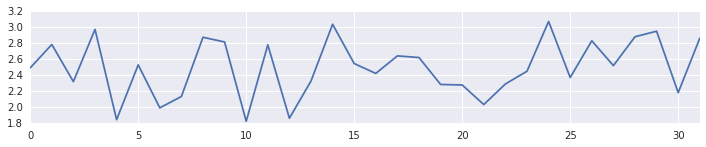

In [21]:
pd.Series(np.abs(v_).sum(0)).plot(figsize=(12,2))

# plots

In [170]:
d = {}
d.update(num_nodes_start = num_nodes_start,
         num_nodes_end = num_nodes_end,
         duplication_mode = duplication_mode,
         mean_loss = mean_loss,
         num_cells = num_cells,
         mean_valid_pplxt = mean_valid_pplxt,
         mean_train_pplxt = mean_train_pplxt,
         num_steps = num_steps,
         summary_frequency = summary_frequency,
         )

In [150]:
def pl():

    title = 'from {} to {} cells. {} mode'.format(num_nodes, max_nn_size, dup_way)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5));
    fig.suptitle(title, fontsize=15)

    ax = pd.Series(mean_loss[1:-1]).plot( ax=axes[0]) #figsize=(15,4),
    xl = 'mean loss (last 10 iters): {:.2f}'.format(np.mean(mean_loss[-10:-1]))
    axes[0].set_xlabel(xl, size=15)
    ax1 = axes[0].twinx()
    ax2 = axes[1].twinx()

    pd.Series(num_cells[1:-1]).plot(ax=ax1, grid=False, c='gray')
    ax.set_ylabel('loss', size=15); ax1.set_ylabel('num_nodes', size=15); ax2.set_ylabel('validation perplexity', size=15)

    axes[1].get_yaxis().set_visible(False)
    axes[1].grid()
    xl = 'mean valid pplxt, last 10 iters: {:.2f}'.format(np.mean(mean_pplxt[-10:]))
    axes[1].set_xlabel(xl, size=15)
    pd.Series(mean_pplxt[1:]).plot(ax=ax2, c='red', )
    
    axes[0].set_ylim(1.4, 2.7)
    ax1.set_ylim(num_nodes * 0.95, max_nn_size * 1.05)
    ax2.set_ylim(4, 11)

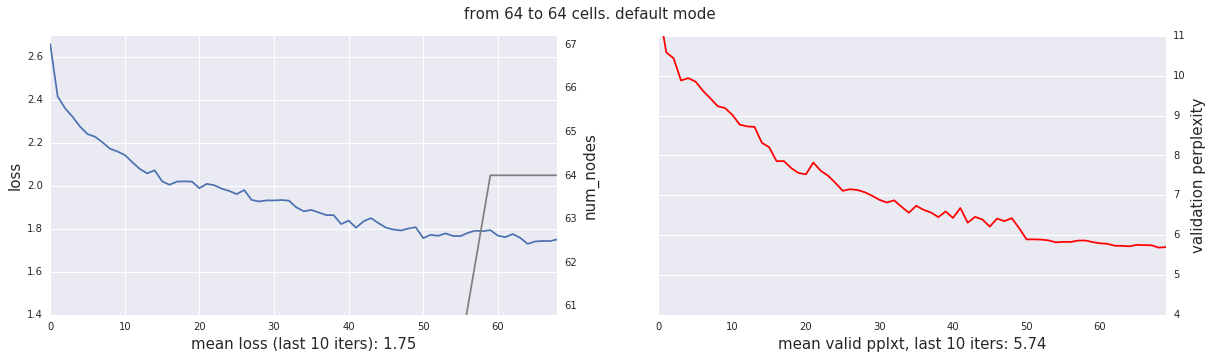

In [165]:
pl()

# Topology

In [187]:
summary_writer = tf.train.SummaryWriter('tmp1/', lstm_graph)
with tf.Session(graph=lstm_graph) as session:
    
    neuron = 3
    mtx = 'im'
    tf.initialize_all_variables().run()
    for mtx in 'ix','im','ib','w', 'b':
        mtrx = lstm_w[mtx]
        print(tf.shape(lstm_w[mtx]).eval())
#         print(mtrx[0,neuron].eval())
        print('Topology testing (in dim, layer dim) =', mtrx.get_shape()[0])
        print('Init', mtx)
        print(lstm_w[mtx].eval())
        
    print('duplicate neuron', neuron)
    duplicate_cell(neuron)
    print(lstm_w[mtx].eval())
    summary_writer = tf.train.SummaryWriter('tmp2/', lstm_graph)


    for mtx in 'ix','im','ib','w', 'b':
        mtrx = lstm_w[mtx]
        print(tf.shape(lstm_w[mtx]).eval())
#         print(mtrx[0,neuron].eval())
        print('Topology testing (in dim, layer dim) =', mtrx.get_shape()[0])
        print('Init', mtx)
        print(lstm_w[mtx].eval())
        
#     neuron = 2
#     print('duplicate neuron', neuron)
#     duplicate_cell(neuron)
#     print(lstm_w[mtx].eval())
#     neuron = 6
#     print('duplicate neuron', neuron)
#     duplicate_cell(neuron)
#     print(lstm_w[mtx].eval())
    print('N nodes =', lstm_w[mtx].get_shape()[0])
    # duplicate_cell(0)


[27  4]
Topology testing (in dim, layer dim) = 27
Init ix
[[-0.18646194  1.56345284  0.27919871  0.17598927]
 [-0.69063634 -1.4326719   0.02884094 -0.94508696]
 [-0.89845008  0.11834093  1.2336551  -0.01372235]
 [ 0.41160068 -0.46296474 -1.02059567  0.21191263]
 [ 1.18682683 -0.10277576 -0.31153274  0.0554245 ]
 [ 0.82856649  0.4333162   0.26203477  0.49557692]
 [ 0.43698472  0.78400642  0.84212673  1.08571506]
 [-0.15625377  0.87299252 -0.7987501   0.17952791]
 [-1.04974353  1.28276515  0.40608639  0.66140622]
 [-0.94111586 -1.20526946  0.06672112  1.0333041 ]
 [-1.5722127   1.5184375  -0.19440264 -0.01089111]
 [-0.56254202 -1.96757746  1.85810542  0.97606671]
 [ 0.13972268 -0.13189696  0.65980715 -0.09137685]
 [ 0.95981562 -0.70445013 -0.31501749  0.42602366]
 [-0.86036432  0.75935328  1.60875821  0.45294476]
 [ 0.55828708 -0.61855274  0.49044982  0.47220743]
 [-1.45180321 -0.25093418  0.05004577  0.29232681]
 [-1.43708563 -0.18774983 -0.02749004 -0.59795952]
 [ 0.27513105  0.0516577

KeyError: 'w'

In [282]:
with tf.Session(graph=lstm_graph) as session:
    for w in 'ix','im','ib':
        print(lstm_w[w].get_shape())

(27, 134)
(134, 134)
(1, 134)


In [317]:
with tf.Session(graph=lstm_graph) as session:
    tf.initialize_all_variables().run()
#     for i in range(134):
    for w in 'ix',:#,'im','ib':
#         slc = tf.slice(lstm_w[w], [0,90], [-1,1])
        slc = lstm_w[w][:,:64]
        print(np.mean(slc.eval()), np.std(slc.eval()))
        slc = lstm_w[w][:,64:]
        print(np.mean(slc.eval()), np.std(slc.eval()))
#         print(lstm_w[w].get_shape())

0.00146557 0.0878597
-0.00167294 0.0887033


In [274]:
w = 'im'
cell_indx = 10
num_nodes = 64

with tf.Session(graph=lstm_graph) as session:
    tf.initialize_all_variables().run()
    slc = tf.slice(lstm_w[w], [0,cell_indx], [-1,1])# + tf.truncated_normal((num_nodes,1), 0.0, 0.01)
    slc = lstm_w[w]
    
#     print(fm.get_shape())
    print(lstm_w['fm'].get_shape())
    
    print(slc.get_shape())
    if 0:
        print(np.mean((slc * 0.).eval()))
        print(np.mean((slc * 0.).eval()))
        print(np.mean((slc).eval()))
        print(np.mean((slc).eval()))
    print(tf.div(slc, tf.constant(2., dtype='float32')).get_shape())
#     print(tf.truncated_normal(slc.get_shape(), 0.0, 0.01).get_shape())
#     print(lstm_w[w].get_shape())
#     print(tf.concat(1, [lstm_w[w], slc]).get_shape())


(134, 134)
(134, 134)
(134, 134)


In [305]:
w = 'im'
cell_indx = 10
num_nodes = 64

with tf.Session(graph=lstm_graph) as session:
    slc = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 1, stddev))
    tf.initialize_all_variables().run()
#     slc = tf.slice(lstm_w[w], [0,cell_indx], [-1,1])# + tf.truncated_normal((num_nodes,1), 0.0, 0.01)
    slc = lstm_w[w] * 1e4
    
    
    print(np.mean((slc).eval()))
    print(np.mean((slc).eval()))
    
    print(saved_output.get_shape())

-1.20327
-1.20327
(64, 126)


---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

        the quick brown fox
        
the model should attempt to output:

        eht kciuq nworb xof
        
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---